# Group 14 - Project FP01
## Time series anomaly detection - Bayesian MLP

In [1]:
import os
import time
import tsfel
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from plots import *
from dataset import *
from metrics import *
from models_functions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal' #'/content/drive/MyDrive/dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Various parameters

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

freq_str = freq.replace(".", "_")
features_folder_normal = f"./features/normal{freq_str}/"
features_folder_collisions = f"./features/collisions{freq_str}/"

#### Data

In [4]:
df_features_normal, df_normal_raw, _, action2int_normal_raw = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, features_folder=None, get_action2int=True)
df_features_collisions, df_collisions_raw, df_collisions_raw_action, action2int_collisions_raw = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, features_folder=None, get_action2int=True)
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1, action2int_collisions_raw_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, features_folder=None, get_action2int=True)
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5, action2int_collisions_raw_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, features_folder=None, get_action2int=True)

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
--- 162.07324838638306 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 48.0153374671936 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


--- 27.90309476852417 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 20.87846803665161 seconds ---


In [5]:
# df_features_normal, df_normal_raw, _, action2int_normal_raw = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, features_folder=f"{features_folder_normal}", get_action2int=True)
# df_features_collisions, df_collisions_raw, df_collisions_raw_action, action2int_collisions_raw = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, features_folder=f"{features_folder_collisions}1_5/", get_action2int=True)
# df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1, action2int_collisions_raw_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, features_folder=f"{features_folder_collisions}1/", get_action2int=True)
# df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5, action2int_collisions_raw_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, features_folder=f"{features_folder_collisions}5/", get_action2int=True)

In [6]:
df_train, df_test = train_test_split(df_features_normal)

In [7]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [8]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
### some labels are missing, so we need to reindex the labels
num_classes = 31
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

### Collisions

In [9]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

### Bayesian MLP model

In [10]:
# Create the MLP tf model
def build_model(hp):

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    hp_drop_rate = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32)
    hp_drop_rate_last = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32)
    inputs = tf.keras.layers.Input(shape=(X_train.values.shape[1],))
    x = inputs
    for i in range(hp.Int("mlp_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
        )(x)
        x = tf.keras.layers.Dropout(rate=hp_drop_rate)(x, training=True)
    x = tf.keras.layers.Dropout(rate=0.5)(x, training=True)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    tf_model = tf.keras.Model(inputs=inputs, outputs=x)
    tf_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                        metrics=['accuracy'])
    return tf_model


In [11]:
# Hyperparams setting
DIR_OUTPUT = "./content/models"
try:
    os.makedirs(DIR_OUTPUT)
except FileExistsError:
    print(f"{DIR_OUTPUT} exists yet.")
tuner = keras_tuner.Hyperband(
    build_model,
    overwrite=True,
    objective='accuracy',
    max_epochs=50,
    factor=3,
    directory=os.path.join(DIR_OUTPUT, "keras_tuner"),
    project_name="keras_tuner_prj")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
print("Grid search training.")
tuner.search(X_train.values, y_train_categorical, epochs=50,
             callbacks=[stop_early,tf.keras.callbacks.TensorBoard(
                 os.path.join(DIR_OUTPUT, "/tmp/tb_logs"))])


Trial 90 Complete [00h 00m 04s]
accuracy: 0.2976680397987366

Best accuracy So Far: 0.9602195024490356
Total elapsed time: 00h 02m 34s


In [12]:
classifier = tuner.get_best_models()[0]
y_test_predict = classifier.predict(X_test.values)

8/8 [==============================] - 0s 1ms/step


Check the model performance

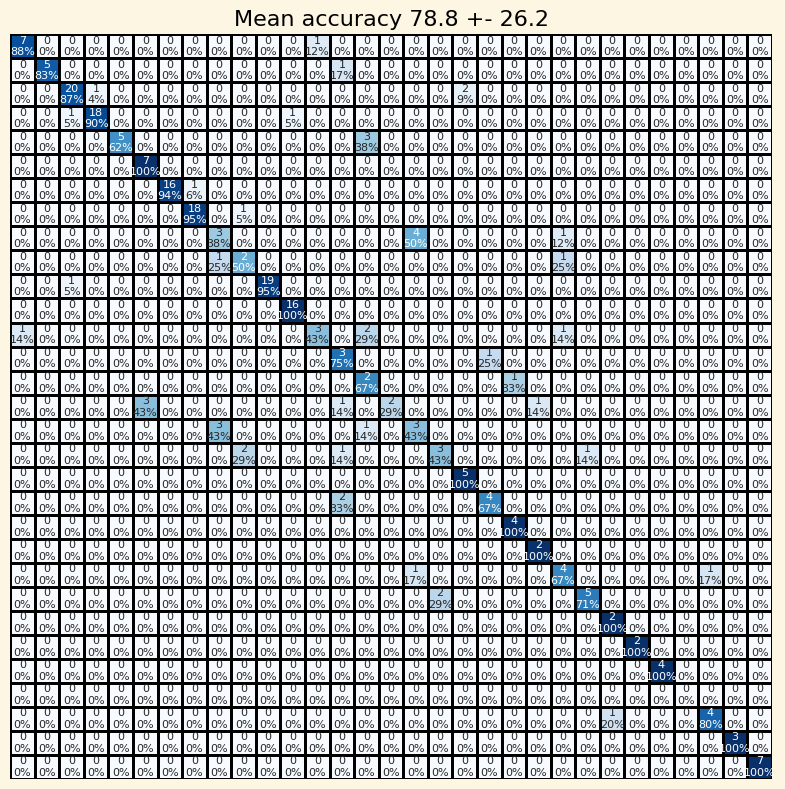

In [13]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int_normal_raw.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_normal_raw.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_normal_raw.values()], fontsize=8, xrotation=90)
plt.tight_layout()

## Compute uncertainty

In [14]:
def compute_uncertainty_dict(preds_array, preds_bayes_mean, y_true):
    uncertainties_bayes = dict()
    uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_true), :]).compute_uncertainty_metrics()
    uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_true), :]).compute_uncertainty_metrics()
    uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()
    return uncertainties_bayes

In [15]:
def plot_uncertainty(uncertainties_bayes):
    fig, axes = plt.subplots(len(uncertainties_bayes['correct'].keys()), 3, figsize=(15, 9))
    for ax, measure in zip(axes, uncertainties_bayes['correct'].keys()):
        ax[0] .set_title(f"Wrong - {measure}")
        ax[0].hist(uncertainties_bayes['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
        ax[1] .set_title(f"Correct - {measure}")
        ax[1].hist(uncertainties_bayes['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
        ax[2] .set_title(f"All - {measure}")
        ax[2].hist(uncertainties_bayes['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    fig.suptitle("Random forest", fontsize=20)
    plt.tight_layout()

In [16]:
n_mc = 10
preds_array = np.array([classifier.predict(X_test.values) for _ in range(n_mc)])
preds_bayes_mean = np.mean(np.array(preds_array), axis = 0)

8/8 [==============================] - 0s 1ms/step


In [17]:
uncertainties_bayes = compute_uncertainty_dict(preds_array, preds_bayes_mean, y_test)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


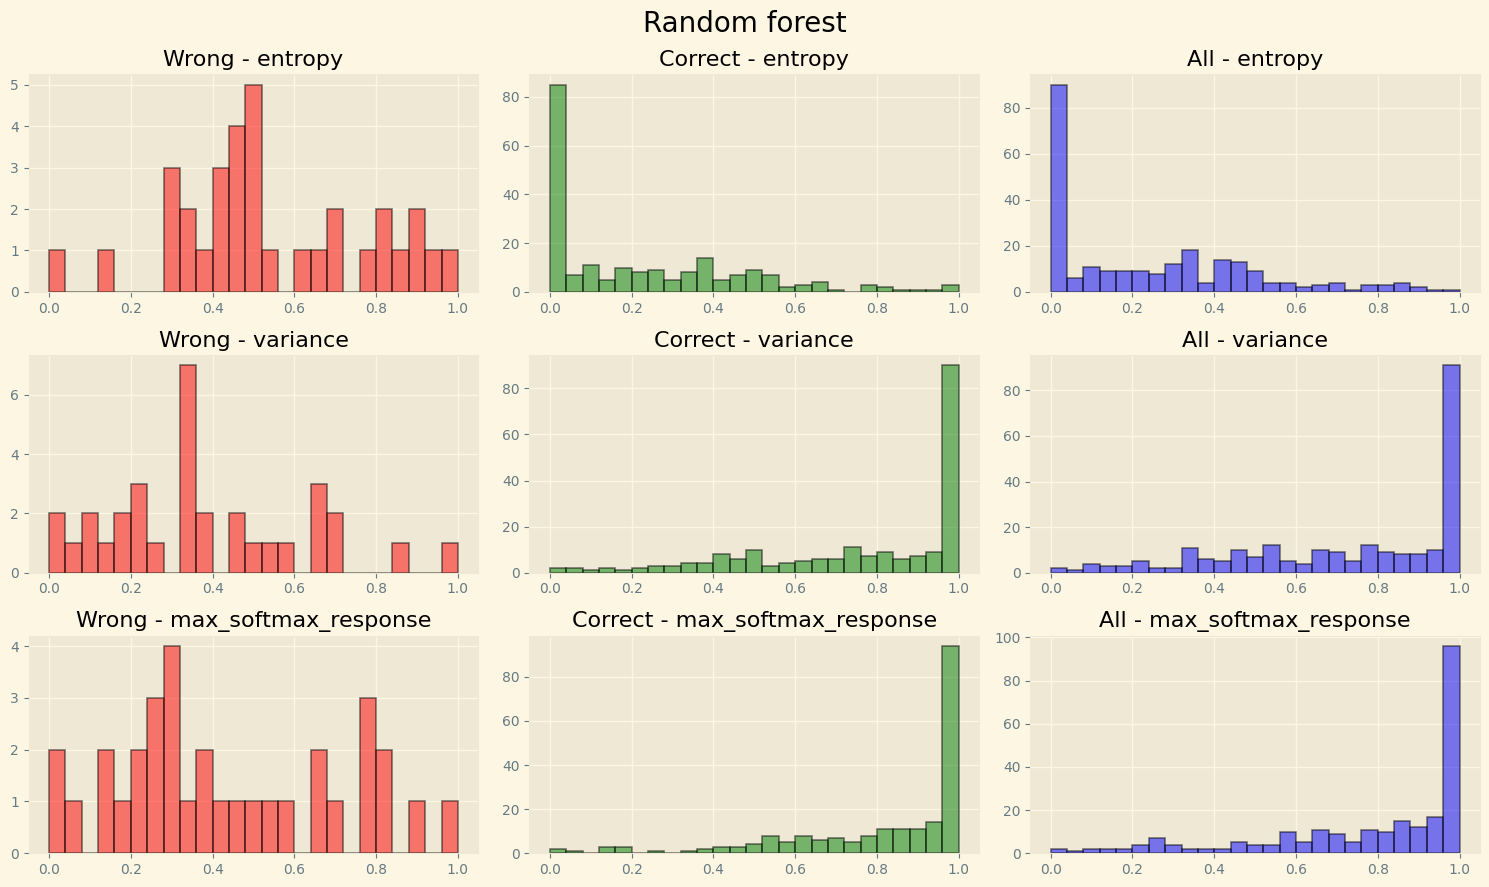

In [18]:
plot_uncertainty(uncertainties_bayes)

## Compute uncertainty

In [19]:
X_test = df_features_collisions.drop(["label", "start", "end"], axis=1)
y_test = df_features_collisions["label"]

X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                           columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()


10/10 [==============================] - 0s 946us/step


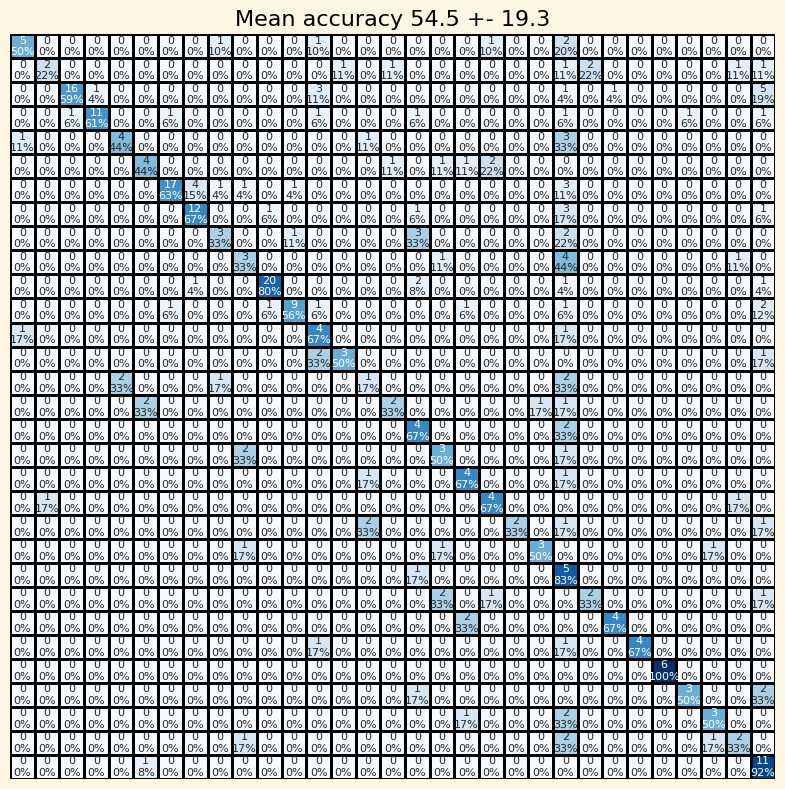

In [20]:
y_test_predict = classifier.predict(X_test.values)

cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int_collisions_raw.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_collisions_raw.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_collisions_raw.values()], fontsize=8, xrotation=90)
plt.tight_layout()

In [21]:
preds_array_collisions = np.array([classifier.predict(X_test.values) for _ in range(n_mc)])
preds_bayes_mean_collision = np.mean(np.array(preds_array_collisions), axis = 0)

10/10 [==============================] - 0s 962us/step


Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


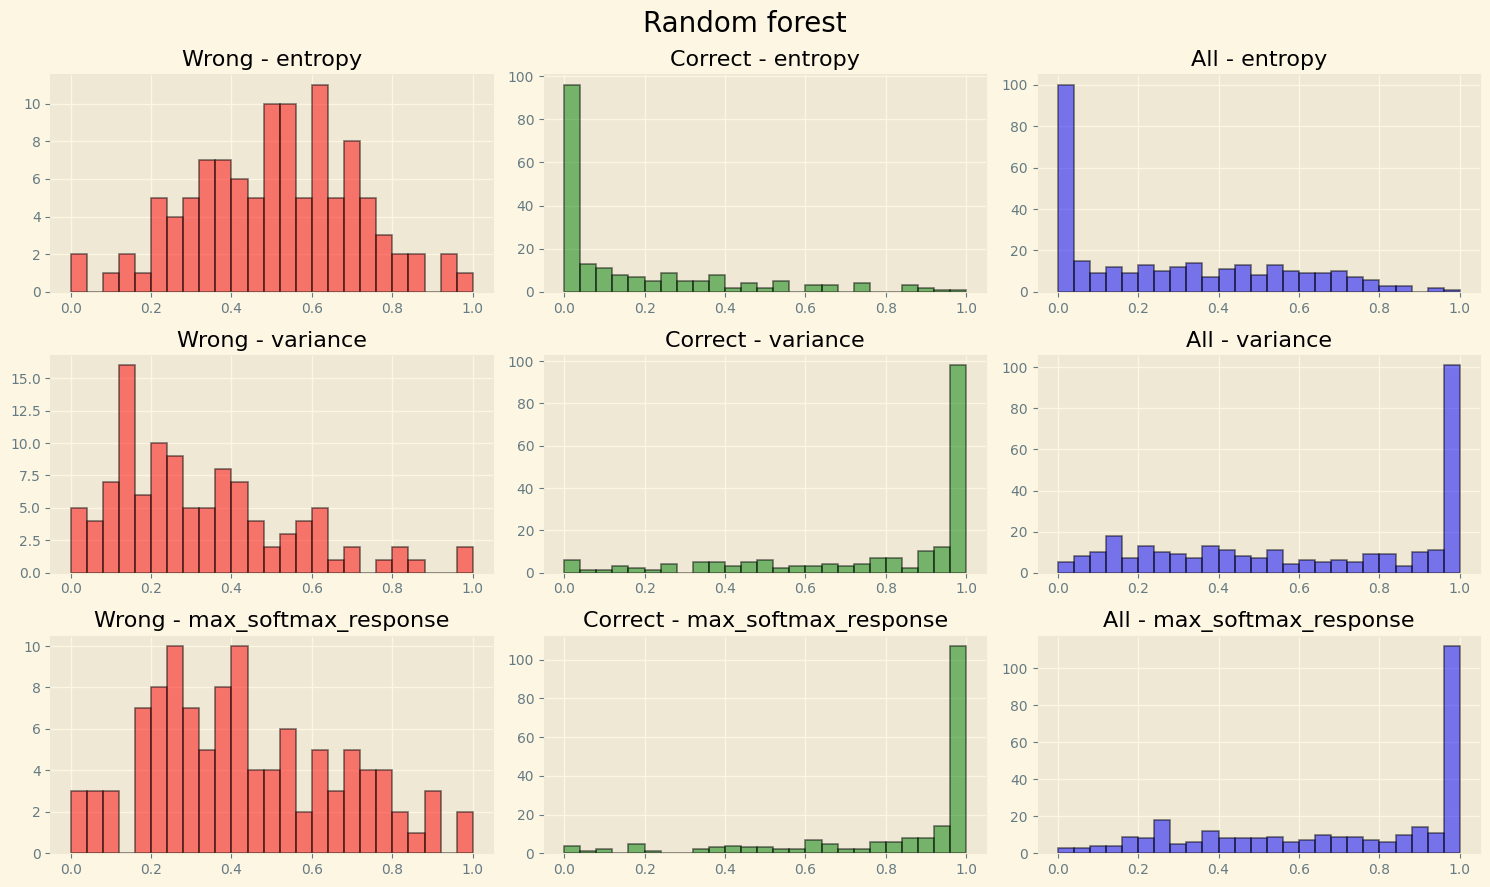

In [22]:
uncertainties_bayes_collisions = compute_uncertainty_dict(preds_array_collisions, preds_bayes_mean_collision, y_test)
plot_uncertainty(uncertainties_bayes_collisions)

In [23]:
X_test_1 = df_features_collisions_1.drop(["label", "start", "end"], axis=1)
y_test_1 = df_features_collisions_1["label"]

X_test_1 = pd.DataFrame(selector_variance.transform(scaler.transform(X_test_1)),
                            columns=X_test_1.columns.values[selector_variance.get_support()])
X_test_1.drop(corr_features, inplace=True, axis=1)
X_test_1 = X_test_1[selected_features].copy()

6/6 [==============================] - 0s 801us/step


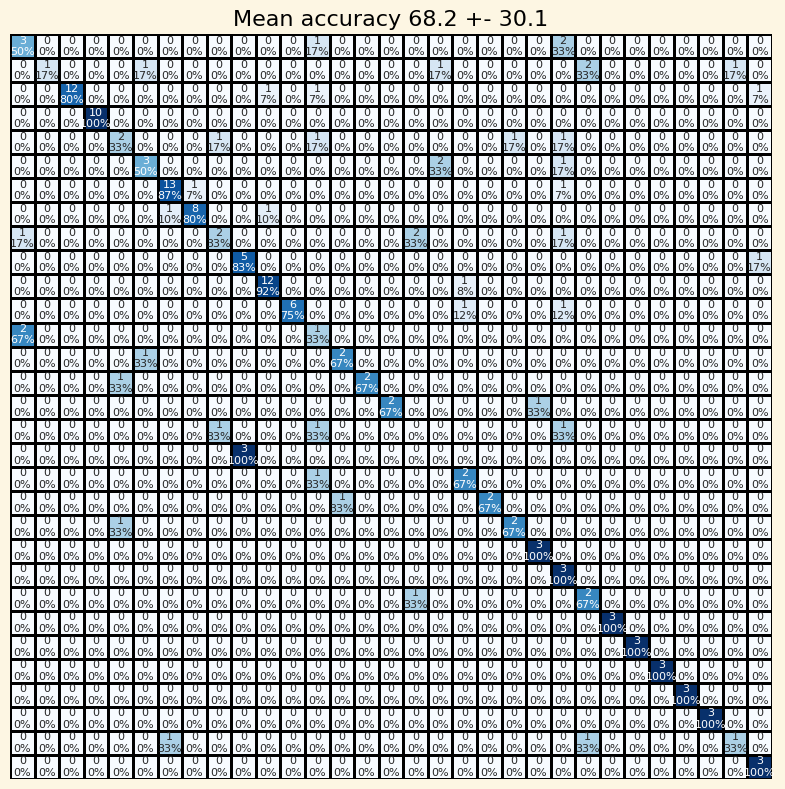

In [24]:
y_test_predict_1 = classifier.predict(X_test_1.values)

cm = confusion_matrix(y_test_1, y_test_predict_1.argmax(axis=1), labels=list(action2int_collisions_raw_1.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_collisions_raw_1.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_collisions_raw_1.values()], fontsize=8, xrotation=90)
plt.tight_layout()

In [25]:
preds_array_collisions_1 = np.array([classifier.predict(X_test_1.values) for _ in range(n_mc)])
preds_bayes_mean_collision_1 = np.mean(np.array(preds_array_collisions_1), axis = 0)

6/6 [==============================] - 0s 931us/step


Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


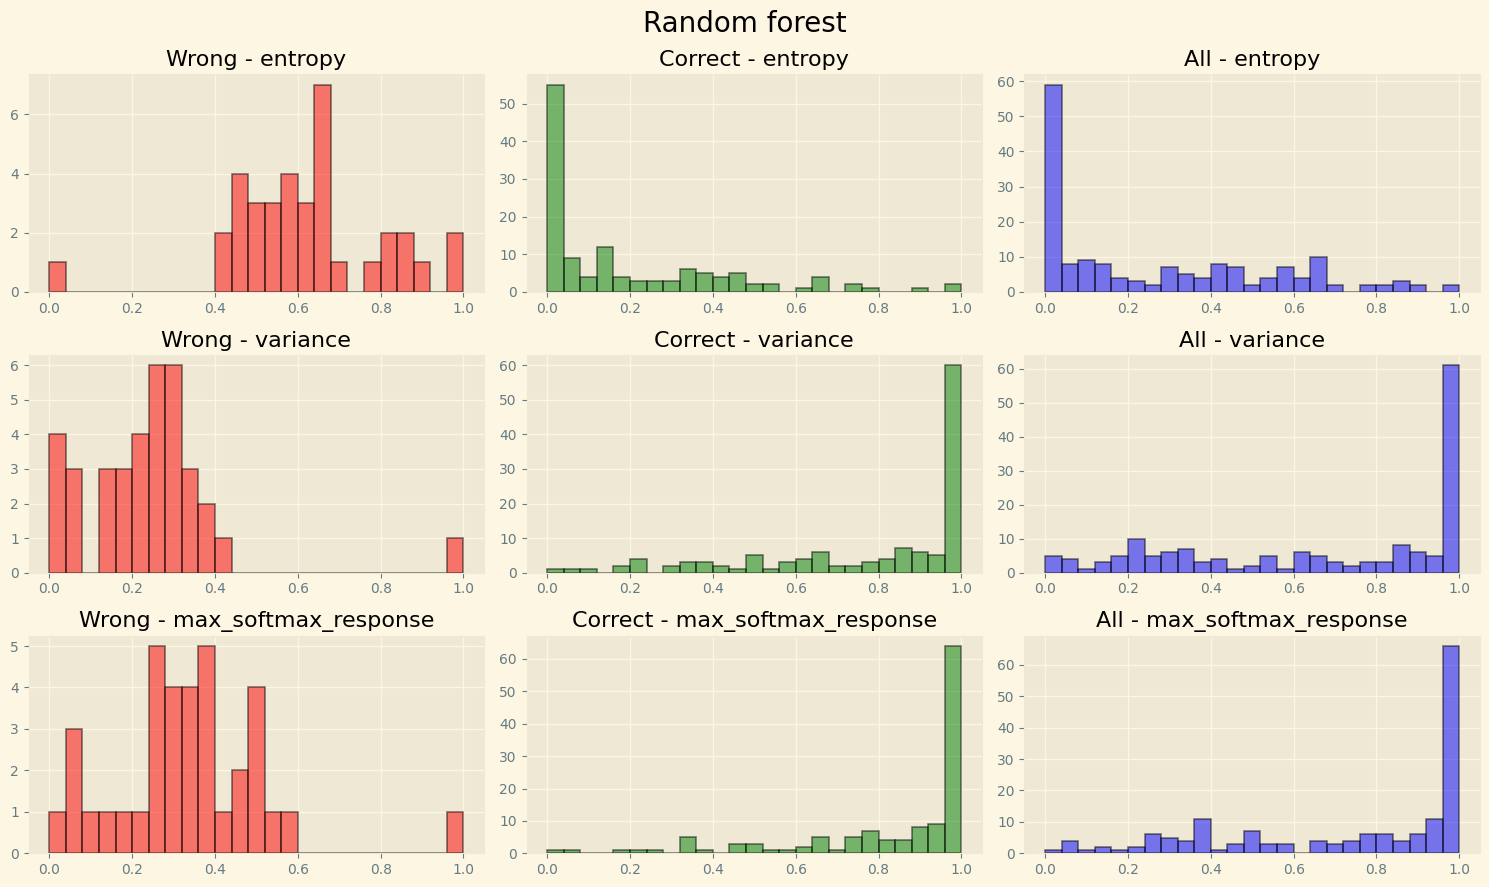

In [26]:
uncertainties_bayes_collisions_1 = compute_uncertainty_dict(preds_array_collisions_1, preds_bayes_mean_collision_1, y_test_1)
plot_uncertainty(uncertainties_bayes_collisions_1)

In [27]:
X_test_5 = df_features_collisions_5.drop(["label", "start", "end"], axis=1)
y_test_5 = df_features_collisions_5["label"]

X_test_5 = pd.DataFrame(selector_variance.transform(scaler.transform(X_test_5)),
                            columns=X_test_5.columns.values[selector_variance.get_support()])
X_test_5.drop(corr_features, inplace=True, axis=1)
X_test_5 = X_test_5[selected_features].copy()

5/5 [==============================] - 0s 1ms/step


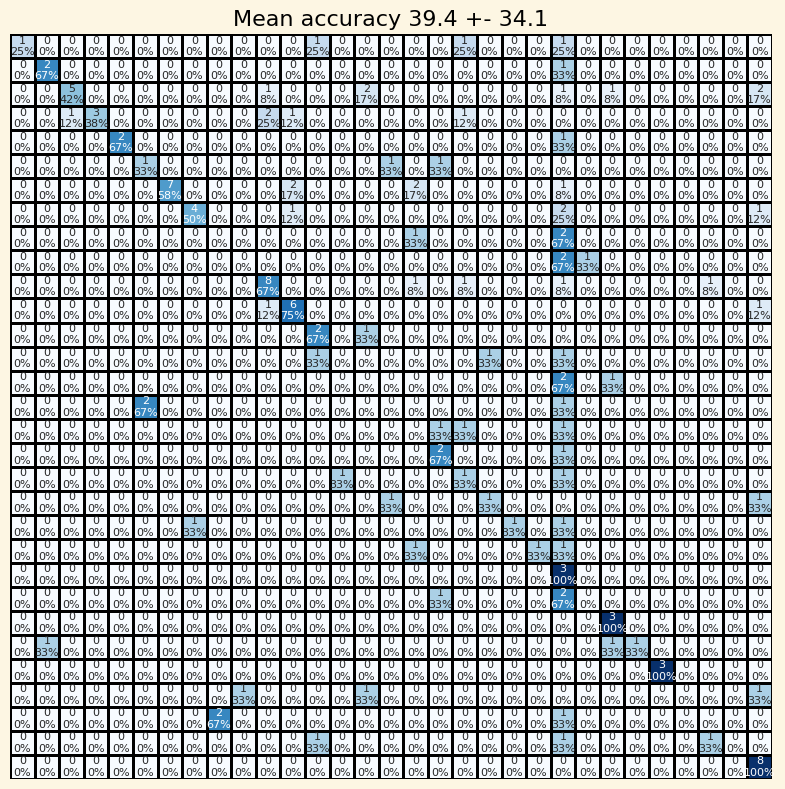

In [28]:
y_test_predict_5 = classifier.predict(X_test_5.values)

cm = confusion_matrix(y_test_5, y_test_predict_5.argmax(axis=1), labels=list(action2int_collisions_raw_5.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_collisions_raw_5.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_collisions_raw_5.values()], fontsize=8, xrotation=90)
plt.tight_layout()

In [29]:
preds_array_collisions_5 = np.array([classifier.predict(X_test_5.values) for _ in range(n_mc)])
preds_bayes_mean_collision_5 = np.mean(np.array(preds_array_collisions_5), axis = 0)

5/5 [==============================] - 0s 1ms/step


Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


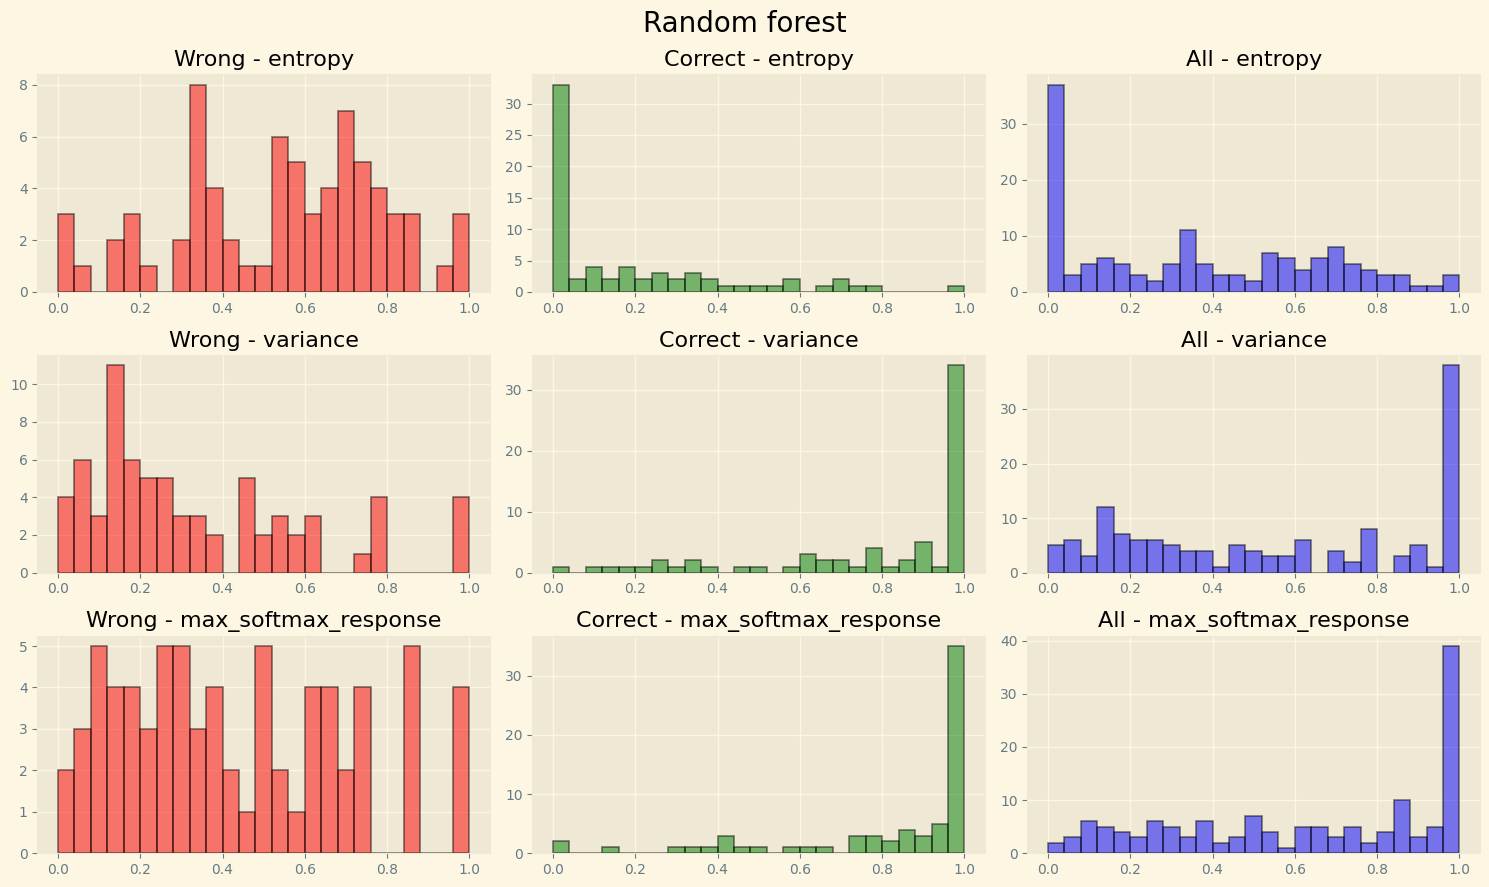

In [30]:
uncertainties_bayes_collisions_5 = compute_uncertainty_dict(preds_array_collisions_5, preds_bayes_mean_collision_5, y_test_5)
plot_uncertainty(uncertainties_bayes_collisions_5)

# Assess TAD algorithm performance via ROC curves

In [31]:
def plot_manual_roc(uncertainties_bayes, df_features_collisions, collisions_init):
    roc_dict = dict()
    for confidence_metric in uncertainties_bayes['correct'].keys():
        confidence = uncertainties_bayes['all'][confidence_metric]
        if confidence_metric == "entropy":
            confidence = 1- confidence
        sens = list()
        fpr = list()
        for threshold in np.arange(0, 1, 0.1):
            df_not_confident = df_features_collisions[confidence <= threshold]
            anomaly_indexes = list()
            tp = 0
            for anomaly in collisions_init:
                for index, row in df_not_confident.iterrows():
                    if anomaly >= row['start'] and anomaly <= row['end']:
                        anomaly_indexes.append(index)
                        tp += 1

            cm_anomaly = np.zeros((2, 2))
            n_samples = len(df_features_collisions)
            n_not_collisions = n_samples - len(collisions_init)
            n_detected = len(df_not_confident)

            fp = n_detected - tp
            fn = len(collisions_init) - tp
            tn = n_not_collisions - fp
            cm_anomaly[0][0] = tn
            cm_anomaly[1][1] = tp
            cm_anomaly[0][1] = fp
            cm_anomaly[1][0] = fn
            sens.append(tp / (tp + fn))
            fpr.append(1 - tn / (fp + tn))
        roc_dict[confidence_metric] = (fpr, sens)
    
    fig, ax = plt.subplots(1, 1)
    for confidence_metric in uncertainties_bayes['correct'].keys():
        ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
    ax.legend();

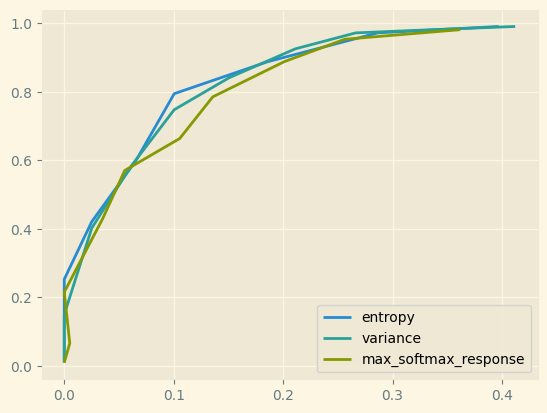

In [32]:
plot_manual_roc(uncertainties_bayes_collisions, df_features_collisions, collisions_init)

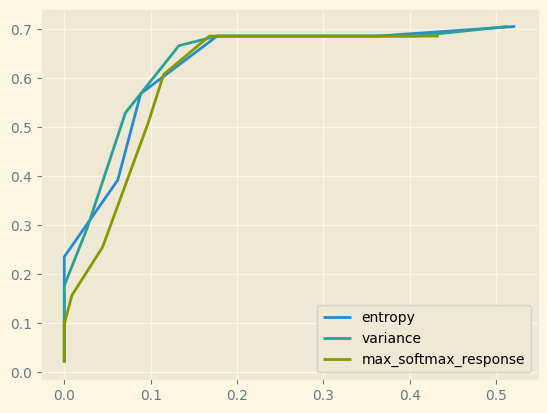

In [33]:
plot_manual_roc(uncertainties_bayes_collisions_1, df_features_collisions_1, collisions_init1)

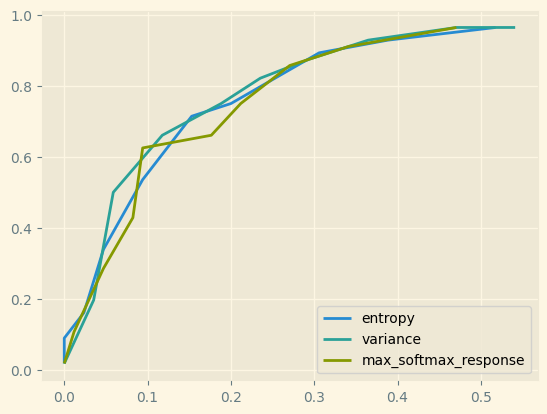

In [34]:
plot_manual_roc(uncertainties_bayes_collisions_5, df_features_collisions_5, collisions_init5)